In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from cs231n.data_utils import load_CIFAR10
from sklearn.utils import shuffle
from six.moves import cPickle as pickle
from six.moves import range
%matplotlib inline

In [2]:
def init_weight_and_bias(M1,M2):
    W = np.random.randn(M1,M2) / np.sqrt(M1 + M2)
    b = np.zeros(M2)
    return W.astype(np.float32), b.astype(np.float32)

In [3]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [4]:
def init_filter(shape,poolsz):
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[1:]) + shape[0]*np.prod(shape[2:] / np.prod(poolsz)))
    return w.astype(np.float32)

In [5]:
def y2indicator(y):
    N = len(y)
    K = len(set(y))
    y_ind = np.zeros((N,K))
    for i in xrange(N):
        y_ind[i,int(y[i])] = 1
    return y_ind

In [6]:
class HiddenLayer(object):
    def __init__(self,M1,M2,an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W,b = init_weight_and_bias(M1,M2)
        self.W = tf.Variable(W)
        self.b = tf.Variable(b)
        self.params = [self.W,self.b]
    def forward(self,X):
        return tf.nn.relu(tf.matmul(X,self.W) + self.b)

In [7]:
class ConvPoolLayer(object):
    def __init__(self,mi,mo,fw=5,fh=5,poolsz=(2,2),strides=[1,1,1,1],padding='SAME'):
        self.W = tf.Variable(tf.truncated_normal([fw,fh,mi,mo],stddev=0.1))
        self.b = tf.Variable(tf.zeros([mo]))
        self.strides = strides
        self.poolsz = poolsz
        self.params = [self.W,self.b]
        self.padding = padding
    def forward(self,X):
        conv_out = tf.nn.conv2d(X,self.W,strides=self.strides,padding='SAME')
        conv_out = tf.nn.bias_add(conv_out,self.b)
        p1,p2 = self.poolsz
        pool_out = tf.nn.max_pool(
            conv_out,
            ksize = [1,p1,p2,1],
            strides = [1,2,2,1],
            padding = self.padding
        )
        return tf.nn.relu(pool_out)

In [8]:
class CNN(object):
    def __init__(self,convpool_layer_sizes,hidden_layer_sizes):
        self.convpool_layer_sizes = convpool_layer_sizes
        self.hidden_layer_sizes = hidden_layer_sizes
        
    def train(self,X,Y,lr=1e-5, mu=0.99, reg=1e-6, decay=0.99999, eps=10e-3, batch_sz=30, epochs=3, show_fig=True):
        #convert hyper-parameter to np.float32
        lr = np.float32(lr)
        mu = np.float32(mu)
        reg = np.float32(reg)
        decay = np.float32(decay)
        eps = np.float32(eps)
        X,Y = shuffle(X,Y)
        X = X.astype(np.float32)
        Y = Y.astype(np.float32)
        X,Y = X[:-1000], Y[:-1000]
        X_valid, Y_valid = X[-1000:], Y[-1000:]
        Y_ind = y2indicator(Y)
        Y_valid_ind = y2indicator(Y_valid)
        # initialize convpool layers
        K = len(set(Y))
        N,w,h,c = X.shape
        mi = c
        outw = 2
        outh = 2
        self.convpool_layers = []
        for mo,fw,fh,ps,st in self.convpool_layer_sizes:
            layer = ConvPoolLayer(mi,mo,fw,fh,ps,st)
            mi = mo 
            self.convpool_layers.append(layer)
        self.hidden_layers = []
        M1 = self.convpool_layer_sizes[-1][0]*outw*outh
        count = 0
        for M2 in self.hidden_layer_sizes:
            hidden = HiddenLayer(M1,M2,count)
            self.hidden_layers.append(hidden)
            M1 = M2
            count += 1
        #logistic regression layer
        W,b = init_weight_and_bias(M1,K)
        self.W = tf.Variable(W,'W_logreg')
        self.b = tf.Variable(b,'b_logreg')
        self.params = [self.W,self.b]
        for c_layer in self.convpool_layers:
            self.params += c_layer.params
        for h_layer in self.hidden_layers:
            self.params += h_layer.params
        #set up variables for tensorflow
        tf_X_train = tf.placeholder(tf.float32,shape=(None,w,h,c))
        tf_Y_train = tf.placeholder(tf.float32,shape=(None,K))
        logits = self.forward(tf_X_train)
        r_cost = reg*np.sum([tf.nn.l2_loss(p) for p in self.params])
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_Y_train,logits=logits))
        loss = cost + r_cost
        prediction = self.predict(tf_X_train)
        train_op = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu).minimize(loss)
        n_batches = N / batch_sz
        train_costs = []
        valid_costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for epoch in xrange(epochs):
                X,Y_ind = shuffle(X,Y_ind)
                for j in xrange(n_batches):
                    X_batch = X[j*batch_sz: (j*batch_sz + batch_sz)]
                    Y_batch = Y_ind[j*batch_sz: (j*batch_sz + batch_sz)]
                    session.run(train_op,feed_dict={tf_X_train:X_batch,tf_Y_train:Y_batch})
                if epoch % 10 == 0:
                    print("calculating training cost:")
                    tc = session.run(loss, feed_dict={tf_X_train: X_batch, tf_Y_train: Y_batch})
                    train_costs.append(tc)
                    pt = session.run(prediction, feed_dict={tf_X_train: X_batch, tf_Y_train: Y_batch})
                    ta = accuracy(pt,Y_batch)
                    print("calculating valid cost:")
                    vc = session.run(cost, feed_dict={tf_X_train: X_valid, tf_Y_train: Y_valid_ind})
                    valid_costs.append(vc)
                    pv = session.run(prediction, feed_dict={tf_X_train: X_valid, tf_Y_train: Y_valid_ind})
                    va = accuracy(pv,Y_valid_ind)
                    print "epoach:", epoch
                    print "training cost:", tc, "training accuracy:", ta
                    print "validation cost:", vc, "validation accuracy:", va
        if show_fig:
            plt.plot(train_costs)
            plt.plot(valid_costs)
            plt.show()
    def forward(self,X):
        Z = X
        for c in self.convpool_layers:
            Z = c.forward(Z)
        #fully connected layer 
        Z_shape = Z.get_shape().as_list()
        Z = tf.reshape(Z, [-1, np.prod(Z_shape[1:])])
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return tf.matmul(Z,self.W) + self.b
    def predict(self,X):
        logits = self.forward(X)
        return tf.nn.softmax(logits)

In [9]:
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [10]:
def draw_sample_image(X,Y):
    labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    X, Y = shuffle(X, Y)
    for i in xrange(20):
        plt.subplot(4,5,i)
        img = X[i]
        plt.imshow(img,cmap='gray')
        plt.axis('off')
        plt.title(labels[Y[i]])
    plt.show()

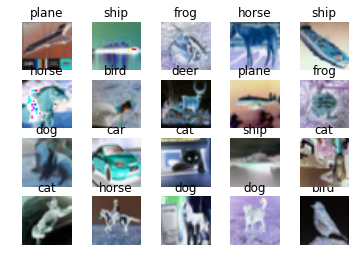

In [11]:
draw_sample_image(X_train,y_train)

calculating training cost:
calculating valid cost:
epoach: 0
training cost: 2.29829 training accuracy: 17.0
validation cost: 2.30651 validation accuracy: 11.9
calculating training cost:
calculating valid cost:
epoach: 10
training cost: 2.03029 training accuracy: 28.0
validation cost: 1.90504 validation accuracy: 28.8
calculating training cost:
calculating valid cost:
epoach: 20
training cost: 1.75247 training accuracy: 37.0
validation cost: 1.68554 validation accuracy: 41.4
calculating training cost:
calculating valid cost:
epoach: 30
training cost: 1.5737 training accuracy: 42.0
validation cost: 1.58771 validation accuracy: 43.5
calculating training cost:
calculating valid cost:
epoach: 40
training cost: 1.38741 training accuracy: 53.0
validation cost: 1.53946 validation accuracy: 46.1
calculating training cost:
calculating valid cost:
epoach: 50
training cost: 1.25142 training accuracy: 57.0
validation cost: 1.47365 validation accuracy: 48.0
calculating training cost:
calculating val

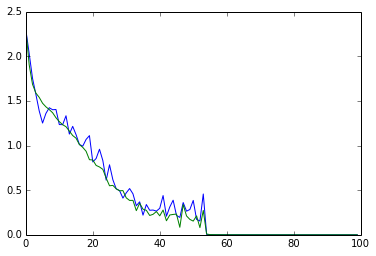

In [12]:
model = CNN(
    convpool_layer_sizes=[
        (20, 5, 5,(3,3),[1,4,4,1]), 
        (20, 5, 5,(3,3),[1,1,1,1])
    ],
    hidden_layer_sizes=[500, 300],
)
model.train(X_train, y_train,batch_sz=100,epochs=1000)